# Kaggle March Madness Challenge 2018

Google Cloud and NCAA® have teamed up to bring you this year’s version of the Kaggle machine learning competition. Another year, another chance to anticipate the upsets, call the probabilities, and put your bracketology skills to the leaderboard test. Kagglers will join the millions of fans who attempt to forecast the outcomes of March Madness® during this year's NCAA Division I Men’s and Women’s Basketball Championships. But unlike most fans, you will pick your bracket using a combination of NCAA’s historical data and your computing power, while the ground truth unfolds on national television.

- Challenge Home: https://www.kaggle.com/c/mens-machine-learning-competition-2018



- Basic Logistic Regression Starter Kernel: https://www.kaggle.com/osciiart/basic-starter-kernel-ncaa-men-s-dataset-with-jp


- Least Squares Starter Kernel: https://www.kaggle.com/baeng72/basic-least-squares-ratings


- NCAA Tournaments Competition Walkthrough: https://www.kaggle.com/asindico/ncaa-tournaments-competition-walkthrough


- Basic Starter Kernel: https://www.kaggle.com/juliaelliott/basic-starter-kernel-ncaa-men-s-dataset


- Feature Engineering with Advanced Statistics: https://www.kaggle.com/lnatml/feature-engineering-with-advanced-stats


- FiveThirtyEight Elo Ratings: https://www.kaggle.com/lpkirwin/fivethirtyeight-elo-ratings


- Extensive NCAA Exploratory Analysis: https://www.kaggle.com/captcalculator/a-very-extensive-ncaa-exploratory-analysis



### Preparation
Import packages and load in initial datasets

In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn import preprocessing
from sklearn import model_selection 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [4]:
df_seeds = pd.read_csv("MNCAATourneySeeds.csv")
df_tour = pd.read_csv("MNCAATourneyCompactResults.csv")

In [5]:
df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [6]:
df_tour.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


### Seed Based Logistic Regression
Using just seeding the predict winner and confidence, use this as baseline model

In [7]:
# Convert seed to int
df_seeds["Seed_int"] = df_seeds["Seed"].str[1:3]
df_seeds["Seed_int"] = df_seeds["Seed_int"].apply(pd.to_numeric)
df_seeds.head()

,Season,Seed,TeamID,Seed_int
0,1985,W01,1207,1
1,1985,W02,1210,2
2,1985,W03,1228,3
3,1985,W04,1260,4
4,1985,W05,1374,5


In [8]:
# Drop unnecessary columns
df_seeds.drop(labels=["Seed"], inplace=True, axis=1)
df_tour.drop(
    labels=["DayNum", "WScore", "LScore", "WLoc", "NumOT"], inplace=True, axis=1
)

In [9]:
df_seeds.head()

,Season,TeamID,Seed_int
0,1985,1207,1
1,1985,1210,2
2,1985,1228,3
3,1985,1260,4
4,1985,1374,5


In [10]:
df_tour.head()

,Season,WTeamID,LTeamID
0,1985,1116,1234
1,1985,1120,1345
2,1985,1207,1250
3,1985,1229,1425
4,1985,1242,1325


In [11]:
# Merge dataframes
df_winseeds = df_seeds.rename(columns={"TeamID": "WTeamID", "Seed_int": "WSeed"})
df_lossseeds = df_seeds.rename(columns={"TeamID": "LTeamID", "Seed_int": "LSeed"})
df_dummy = pd.merge(
    left=df_tour, right=df_winseeds, how="left", on=["Season", "WTeamID"]
)
df_concat = pd.merge(left=df_dummy, right=df_lossseeds, on=["Season", "LTeamID"])
df_concat["SeedDiff"] = df_concat.WSeed - df_concat.LSeed
df_concat.head()

,Season,WTeamID,LTeamID,WSeed,LSeed,SeedDiff
0,1985,1116,1234,9,8,1
1,1985,1120,1345,11,6,5
2,1985,1207,1250,1,16,-15
3,1985,1229,1425,9,8,1
4,1985,1242,1325,3,14,-11


In [12]:
# Create training data set
df_wins = pd.DataFrame()
df_wins["SeedDiff"] = df_concat["SeedDiff"]
df_wins["Result"] = 1

df_losses = pd.DataFrame()
df_losses["SeedDiff"] = -df_concat["SeedDiff"]
df_losses["Result"] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,SeedDiff,Result
0,1,1
1,5,1
2,-15,1
3,1,1
4,-11,1


In [13]:
X_train = df_predictions["SeedDiff"].values.reshape(-1, 1)
Y_train = df_predictions["Result"].values
X_train, Y_train = shuffle(X_train, Y_train)

In [14]:
# Create and test model
logreg = LogisticRegression()
params = {"C": np.logspace(start=-5, stop=5, num=10)}
clf = GridSearchCV(logreg, params, scoring="neg_log_loss", refit=True)
clf.fit(X_train, Y_train)
print(
    "Best log_loss: {:.4}, with best C: {}".format(
        clf.best_score_, clf.best_params_["C"]
    )
)

Best log_loss: -0.5601, with best C: 0.021544346900318846


In [15]:
# Store model results
df_results = pd.DataFrame(
    {"Type": ["Seed Based Logistic Regression"], "Log Loss": [clf.best_score_]},
    columns=["Type", "Log Loss"],
)
df_results.head()

,Type,Log Loss
0,Seed Based Logistic Regression,-0.560064


Text(0, 0.5, 'P(Team 1)')

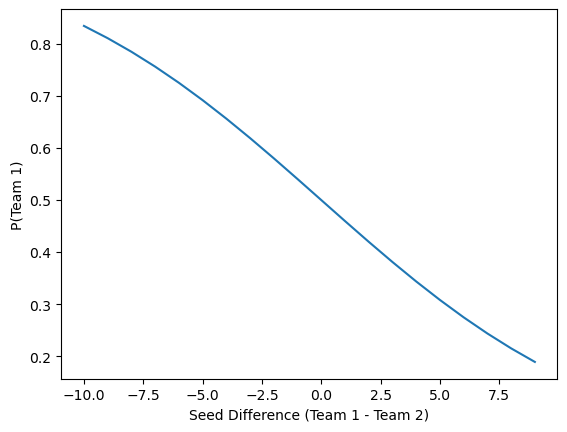

In [16]:
# Vizualization
X = np.arange(-10, 10).reshape(-1, 1)
preds = clf.predict_proba(X)[:, 1]

plt.plot(X, preds)
plt.xlabel("Seed Difference (Team 1 - Team 2)")
plt.ylabel("P(Team 1)")

### Average Ranking Based Logistic Regression Model

In [17]:
df_massey = pd.read_csv("MMasseyOrdinals.csv")

In [18]:
df_massey.head()

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
0,2003,35,SEL,1102,159
1,2003,35,SEL,1103,229
2,2003,35,SEL,1104,12
3,2003,35,SEL,1105,314
4,2003,35,SEL,1106,260


In [20]:
df_massey.head()

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
0,2003,35,SEL,1102,159
1,2003,35,SEL,1103,229
2,2003,35,SEL,1104,12
3,2003,35,SEL,1105,314
4,2003,35,SEL,1106,260


In [21]:
# Create composite final rankings
final_day = 133
df_final_rankings = df_massey.loc[df_massey["RankingDayNum"] == final_day]
df_final_rankings = df_final_rankings.groupby(["Season", "TeamID"])[
    "OrdinalRank"
].mean()
df_final_rankings = df_final_rankings.reset_index()
df_final_rankings.rename(columns={"OrdinalRank": "Avg. Rank"}, inplace=True)

In [22]:
df_final_rankings.head()

,Season,TeamID,Avg. Rank
0,2003,1102,156.03125
1,2003,1103,168.00000
2,2003,1104,38.03125
3,2003,1105,308.96875
4,2003,1106,262.68750


In [23]:
df_tour = pd.read_csv("MNCAATourneyCompactResults.csv")
df_tour.drop(labels=["WLoc", "NumOT"], inplace=True, axis=1)
df_tour.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,1985,136,1116,63,1234,54
1,1985,136,1120,59,1345,58
2,1985,136,1207,68,1250,43
3,1985,136,1229,58,1425,55
4,1985,136,1242,49,1325,38


In [24]:
# Join tournament results
df_win_ranks = df_final_rankings.rename(
    columns={"TeamID": "WTeamID", "Avg. Rank": "WAvgRank"}
)
df_loss_ranks = df_final_rankings.rename(
    columns={"TeamID": "LTeamID", "Avg. Rank": "LAvgRank"}
)
df_dummy = pd.merge(
    left=df_tour, right=df_win_ranks, how="left", on=["Season", "WTeamID"]
)
df_concat = pd.merge(left=df_dummy, right=df_loss_ranks, on=["Season", "LTeamID"])
df_concat["ScoreDiff"] = df_concat["WScore"] - df_concat["LScore"]
df_concat["RankDiff"] = df_concat["WAvgRank"] - df_concat["LAvgRank"]
df_total = df_concat[
    ["Season", "DayNum", "WTeamID", "LTeamID", "WAvgRank", "LAvgRank", "RankDiff"]
]
df_total.head()

,Season,DayNum,WTeamID,LTeamID,WAvgRank,LAvgRank,RankDiff
0,2003,134,1421,1411,240.343750,239.281250,1.062500
1,2003,136,1112,1436,2.676471,153.125000,-150.448529
2,2003,136,1113,1272,36.000000,21.705882,14.294118
3,2003,136,1141,1166,45.687500,20.735294,24.952206
4,2003,136,1143,1301,36.406250,50.312500,-13.906250


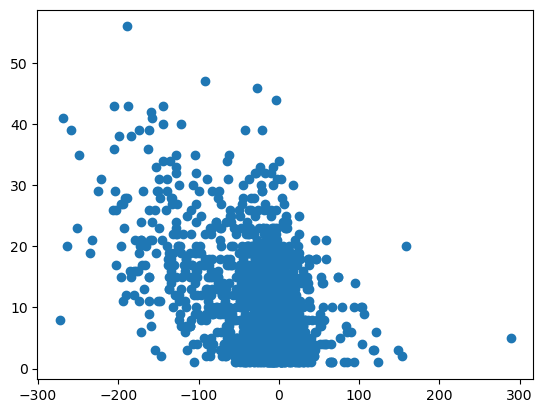

In [25]:
# Is ranking difference correlated with score difference?
plt.scatter(df_concat["RankDiff"], df_concat["ScoreDiff"])

In [26]:
# Create testing and training sets
df_wins = pd.DataFrame()
df_wins["RankDiff"] = df_total["RankDiff"]
df_wins["Result"] = 1

df_losses = pd.DataFrame()
df_losses["RankDiff"] = -df_total["RankDiff"]
df_losses["Result"] = 0

In [27]:
df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,RankDiff,Result
0,1.062500,1
1,-150.448529,1
2,14.294118,1
3,24.952206,1
4,-13.906250,1


In [28]:
X_train = df_predictions["RankDiff"].values.reshape(-1, 1)
Y_train = df_predictions["Result"].values
X_train, Y_train = shuffle(X_train, Y_train)

In [35]:
logreg2 = LogisticRegression()
params = {"C": np.logspace(start=-5, stop=5, num=10)}
clf = GridSearchCV(logreg, params, scoring="neg_log_loss", refit=True)
clf.fit(X_train, Y_train)
print(
    "Best log_loss: {:.4}, with best C: {}".format(
        clf.best_score_, clf.best_params_["C"]
    )
)

Best log_loss: -0.5648, with best C: 0.0016681005372000592


In [39]:
df_results = df_results._append(
    pd.DataFrame(
        {
            "Type": ["Avg. Ranking Based Logistic Regression"],
            "Log Loss": [clf.best_score_],
        },
        columns=["Type", "Log Loss"],
    )
)
df_results

,Type,Log Loss
0,Avg. Ranking Based Logistic Regression,-0.564826
0,Avg. Ranking Based Logistic Regression,-0.564826
0,Avg. Ranking Based Logistic Regression,-0.564826


### FiveThirtyEight Elo Logistic Regression Implementation

In [40]:
# Homecourt Bonus
HOME_ADVANTAGE = 100
# Learning rate
K = 22

In [41]:
rs = pd.read_csv("MRegularSeasonCompactResults.csv")
rs.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


In [42]:
# Teams
team_ids = set(rs.WTeamID).union(set(rs.LTeamID))
len(team_ids)

378

In [43]:
# Score lookup dict
elo_dict = dict(zip(list(team_ids), [1500] * len(team_ids)))

In [44]:
# New columns to help us iteratively update elos
rs["margin"] = rs.WScore - rs.LScore
rs["w_elo"] = None
rs["l_elo"] = None

In [45]:
# Elo calculation
def elo_pred(elo1, elo2):
    return 1.0 / (10.0 ** (-(elo1 - elo2) / 400.0) + 1.0)


def expected_margin(elo_diff):
    return 7.5 + 0.006 * elo_diff


def elo_update(w_elo, l_elo, margin):
    elo_diff = w_elo - l_elo
    pred = elo_pred(w_elo, l_elo)
    mult = ((margin + 3.0) ** 0.8) / expected_margin(elo_diff)
    update = K * mult * (1 - pred)
    return (pred, update)

In [46]:
# Check order
assert np.all(rs.index.values == np.array(range(rs.shape[0]))), "Index is out of order."

In [47]:
# Iterate through all games
preds = []
for i in range(rs.shape[0]):

    # Get key data from current row
    w = rs.at[i, "WTeamID"]
    l = rs.at[i, "LTeamID"]
    margin = rs.at[i, "margin"]
    wloc = rs.at[i, "WLoc"]

    # Does either team get a home-court advantage?
    (
        w_ad,
        l_ad,
    ) = (
        0.0,
        0.0,
    )
    if wloc == "H":
        w_ad += HOME_ADVANTAGE
    elif wloc == "A":
        l_ad += HOME_ADVANTAGE

    # Get elo updates as a result of the game
    pred, update = elo_update(elo_dict[w] + w_ad, elo_dict[l] + l_ad, margin)
    elo_dict[w] += update
    elo_dict[l] -= update
    preds.append(pred)

    # Stores new elos in the games dataframe
    rs.loc[i, "w_elo"] = elo_dict[w]
    rs.loc[i, "l_elo"] = elo_dict[l]

In [48]:
def final_elo_per_season(df, team_id):
    d = df.copy()
    d = d.loc[(d.WTeamID == team_id) | (d.LTeamID == team_id), :]
    d.sort_values(["Season", "DayNum"], inplace=True)
    d.drop_duplicates(["Season"], keep="last", inplace=True)
    w_mask = d.WTeamID == team_id
    l_mask = d.LTeamID == team_id
    d["season_elo"] = None
    d.loc[w_mask, "season_elo"] = d.loc[w_mask, "w_elo"]
    d.loc[l_mask, "season_elo"] = d.loc[l_mask, "l_elo"]
    out = pd.DataFrame(
        {"team_id": team_id, "season": d.Season, "season_elo": d.season_elo}
    )
    return out

In [49]:
df_list = [final_elo_per_season(rs, i) for i in team_ids]
season_elos = pd.concat(df_list)

In [50]:
season_elos.head()

,team_id,season,season_elo
134286,1101,2014,1317.046906
139681,1101,2015,1201.111852
145038,1101,2016,1213.735772
150369,1101,2017,1233.861895
155760,1101,2018,1295.57557


In [52]:
# Logistic Regression

df_tour = pd.read_csv("MNCAATourneyCompactResults.csv")
df_tour.drop(
    labels=["DayNum", "WLoc", "NumOT", "WScore", "LScore"], inplace=True, axis=1
)

df_win_elos = season_elos.rename(
    columns={"team_id": "WTeamID", "season": "Season", "season_elo": "W_Elo"}
)  #
df_loss_elos = season_elos.rename(
    columns={"team_id": "LTeamID", "season": "Season", "season_elo": "L_Elo"}
)  #
df_dummy = pd.merge(
    left=df_tour, right=df_win_elos, how="left", on=["Season", "WTeamID"]
)
df_concat = pd.merge(left=df_dummy, right=df_loss_elos, on=["Season", "LTeamID"])
df_concat["Elo_Diff"] = df_concat["W_Elo"] - df_concat["L_Elo"]
df_concat.head()

,Season,WTeamID,LTeamID,W_Elo,L_Elo,Elo_Diff
0,1985,1116,1234,1591.577794,1611.13548,-19.557686
1,1985,1120,1345,1571.383932,1582.630293,-11.246362
2,1985,1207,1250,1748.491322,1430.346043,318.14528
3,1985,1229,1425,1582.036358,1578.096133,3.940226
4,1985,1242,1325,1615.962789,1600.978706,14.984084


In [172]:
from sklearn.preprocessing import MinMaxScaler

df_win_elos

# Create an instance of MinMaxScaler
scaler = MinMaxScaler(feature_range=(50, 100))

# Scale the 'Elo_Scaled' column
df_win_elos["Elo_Scaled"] = scaler.fit_transform(df_win_elos[["Elo_Scaled"]])

df_win_elos

,WTeamID,Season,Elo_Scaled,MeanRank_Scaled,W_Composite
0,1101,2014,68.474132,0.054558,0.159533
1,1101,2015,64.186441,0.073204,0.143379
2,1101,2016,64.653318,0.137431,0.189309
3,1101,2017,65.397654,0.154006,0.205321
4,1101,2018,67.680045,0.267956,0.296504
...,...,...,...,...,...
13013,1473,2023,68.177992,0.055939,0.158479
13015,1474,2023,73.442144,0.422652,0.438049
13017,1475,2023,71.361724,0.226519,0.293424
13019,1476,2023,70.335332,0.091851,0.196803


In [39]:
# Prediction dataframe
df_wins = pd.DataFrame()
df_wins["Elo_Diff"] = df_concat["Elo_Diff"]
df_wins["Result"] = 1

df_losses = pd.DataFrame()
df_losses["Elo_Diff"] = -df_concat["Elo_Diff"]
df_losses["Result"] = 0

In [54]:
df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,RankDiff,Result
0,1.062500,1
1,-150.448529,1
2,14.294118,1
3,24.952206,1
4,-13.906250,1


In [56]:
X_train = df_predictions["RankDiff"].values.reshape(-1, 1)
Y_train = df_predictions["Result"].values
X_train, Y_train = shuffle(X_train, Y_train)

In [42]:
# Fit and test model
logreg2 = LogisticRegression()
params = {"C": np.logspace(start=-5, stop=5, num=10)}
clf = GridSearchCV(logreg, params, scoring="neg_log_loss", refit=True)
clf.fit(X_train, Y_train)
print(
    "Best log_loss: {:.4}, with best C: {}".format(
        clf.best_score_, clf.best_params_["C"]
    )
)

Best log_loss: -0.5428, with best C: 0.0001291549665014884


In [43]:
# Store model results
df_results = df_results.append(
    pd.DataFrame(
        {
            "Type": ["FiveThirtyEight Elo Logistic Regression"],
            "Log Loss": [clf.best_score_],
        },
        columns=["Type", "Log Loss"],
    )
)
df_results.head()

,Type,Log Loss
0,Seed Based Logistic Regression,-0.553150
0,Avg. Ranking Based Logistic Regression,-0.546793
0,FiveThirtyEight Elo Logistic Regression,-0.542821


### Select Ranking Systems

In [57]:
df_tour = pd.read_csv("MNCAATourneyCompactResults.csv")
df_tour.drop(
    labels=["DayNum", "WLoc", "NumOT", "WScore", "LScore"], inplace=True, axis=1
)
df_tour.head()

,Season,WTeamID,LTeamID
0,1985,1116,1234
1,1985,1120,1345
2,1985,1207,1250
3,1985,1229,1425
4,1985,1242,1325


In [58]:
# Get list of all ranking systems
ranking_types = df_massey["SystemName"].unique().tolist()
ranking_types = [
    e
    for e in ranking_types
    if e not in ("MIC", "GC", "RAG", "TOL", "EBB", "BP5", "MPI", "BOW", "CTL")
]
print(ranking_types)

['SEL', 'AP', 'BIH', 'DUN', 'ENT', 'GRN', 'IMS', 'MAS', 'MKV', 'MOR', 'POM', 'RPI', 'SAG', 'SAU', 'SE', 'STR', 'USA', 'WLK', 'WOB', 'BOB', 'DWH', 'ERD', 'ECK', 'BRZ', 'ARG', 'RTH', 'WOL', 'HOL', 'COL', 'DOL', 'GRS', 'HER', 'TSR', 'WTE', 'BD', 'MGY', 'CNG', 'SIM', 'DES', 'JON', 'LYN', 'NOR', 'RM', 'REI', 'ACU', 'BCM', 'CMV', 'SAP', 'DC', 'KLK', 'WIL', 'ROH', 'RIS', 'REN', 'SCR', 'DOK', 'PIG', 'KPK', 'PKL', 'TRX', 'MB', 'JCI', 'PH', 'LYD', 'KRA', 'RTR', 'UCS', 'ISR', 'CPR', 'BKM', 'JEN', 'REW', 'STH', 'SPW', 'RSE', 'PGH', 'CPA', 'RTB', 'HKB', 'BPI', 'TW', 'NOL', 'DC2', 'DCI', 'OMY', 'LMC', 'RT', 'KEL', 'KMV', 'RTP', 'TMR', 'AUS', 'ROG', 'PTS', 'KOS', 'PEQ', 'ADE', 'BNM', 'CJB', 'BUR', 'HAT', 'MSX', 'BBT', '7OT', 'SFX', 'EBP', 'TBD', 'CRO', 'D1A', 'TPR', 'BLS', 'DII', 'KBM', 'TRP', 'LOG', 'SP', 'STF', 'WMR', 'PPR', 'STS', 'UPS', 'SPR', 'MvG', 'TRK', 'BWE', 'HAS', 'FSH', 'DAV', 'KPI', 'FAS', 'MCL', 'HRN', 'RSL', 'SMN', 'DDB', 'INP', 'JRT', 'ESR', 'FMG', 'PRR', 'SMS', 'HKS', 'MUZ', 'OCT', '

In [59]:
# Iterate through each ranking and check log loss
def logreg_type(mytype):
    df_type = df_massey.loc[
        (df_massey["RankingDayNum"] == final_day) & (df_massey["SystemName"] == mytype)
    ]
    df_type = df_type.drop(labels=["RankingDayNum", "SystemName"], axis=1)
    df_type.rename(columns={"OrdinalRank": "Type Rank"}, inplace=True)

    df_win_ranks = df_type.rename(
        columns={"TeamID": "WTeamID", "Type Rank": "WTypeRank"}
    )
    df_loss_ranks = df_type.rename(
        columns={"TeamID": "LTeamID", "Type Rank": "LTypeRank"}
    )
    df_dummy = pd.merge(
        left=df_tour, right=df_win_ranks, how="left", on=["Season", "WTeamID"]
    )
    df_concat = pd.merge(left=df_dummy, right=df_loss_ranks, on=["Season", "LTeamID"])
    df_concat["RankDiff"] = df_concat["WTypeRank"] - df_concat["LTypeRank"]
    df_total = df_concat[
        ["Season", "WTeamID", "LTeamID", "WTypeRank", "LTypeRank", "RankDiff"]
    ]

    if len(df_total) > 980:
        df_wins = pd.DataFrame()
        df_wins["RankDiff"] = df_total["RankDiff"]
        df_wins["Result"] = 1
        df_losses = pd.DataFrame()
        df_losses["RankDiff"] = -df_total["RankDiff"]
        df_losses["Result"] = 0

        df_predictions = pd.concat((df_wins, df_losses))

        X_train = df_predictions["RankDiff"].values.reshape(-1, 1)
        Y_train = df_predictions["Result"].values
        X_train, Y_train = shuffle(X_train, Y_train)
        if np.isnan(np.sum(X_train)) == False:

            logregtype = LogisticRegression()
            params = {"C": np.logspace(start=-5, stop=5, num=10)}
            clf = GridSearchCV(logregtype, params, scoring="neg_log_loss", refit=True)
            clf.fit(X_train, Y_train)

            print(
                "{} - Best log_loss: {:.4}, with best C: {}".format(
                    mytype, clf.best_score_, clf.best_params_["C"]
                )
            )
            return pd.DataFrame(
                {"Type": [mytype], "Log Loss": [clf.best_score_]},
                columns=["Type", "Log Loss"],
            )
        return pd.DataFrame(
            {"Type": [mytype], "Log Loss": [999]}, columns=["Type", "Log Loss"]
        )
    return pd.DataFrame(
        {"Type": [mytype], "Log Loss": [999]}, columns=["Type", "Log Loss"]
    )

In [61]:
df_type_scores = pd.DataFrame(columns=["Type", "Log Loss"])
for mytype in ranking_types:
    df_type_scores = df_type_scores._append(logreg_type(mytype))

SEL - Best log_loss: -0.5761, with best C: 0.0001291549665014884
BIH - Best log_loss: -0.5783, with best C: 0.0001291549665014884
DUN - Best log_loss: -0.586, with best C: 0.0001291549665014884
MAS - Best log_loss: -0.5801, with best C: 0.0001291549665014884
MOR - Best log_loss: -0.5654, with best C: 0.0001291549665014884
POM - Best log_loss: -0.5662, with best C: 0.0001291549665014884
RPI - Best log_loss: -0.5687, with best C: 0.0001291549665014884
SAG - Best log_loss: -0.5648, with best C: 0.0001291549665014884
WLK - Best log_loss: -0.5657, with best C: 0.0001291549665014884
WOB - Best log_loss: -0.5796, with best C: 0.0016681005372000592
RTH - Best log_loss: -0.5658, with best C: 0.0001291549665014884
WOL - Best log_loss: -0.5705, with best C: 0.0016681005372000592
COL - Best log_loss: -0.5775, with best C: 0.0001291549665014884
DOL - Best log_loss: -0.5728, with best C: 0.0001291549665014884
CNG - Best log_loss: -0.5551, with best C: 0.0001291549665014884
WIL - Best log_loss: -0.57

In [62]:
df_type_scores = df_type_scores.loc[df_type_scores["Log Loss"] != 999]
df_type_scores.sort_values(by="Log Loss", ascending=False, inplace=True)
df_type_scores

,Type,Log Loss
0,CNG,-0.555100
0,SAG,-0.564850
0,MOR,-0.565393
0,WLK,-0.565750
0,RTH,-0.565829
0,POM,-0.566166
0,RPI,-0.568674
0,WOL,-0.570460
0,DOL,-0.572767
0,DOK,-0.575021


### Final Model Selection
Right now, I have a couple different metric options to test, tune, and consider for use in the upcoming tournament:
1. FiveThirtyEight Elo Ratings
2. Average Select Ranking Systems
3. Composite Model

### 1. FiveThirtyEight Elo Ratings Model

In [63]:
df_tour = pd.read_csv("MNCAATourneyCompactResults.csv")
df_tour.drop(labels=["WLoc", "NumOT", "WScore", "LScore"], inplace=True, axis=1)

df_win_elos = season_elos.rename(
    columns={"team_id": "WTeamID", "season_elo": "W_Elo", "season": "Season"}
)
df_loss_elos = season_elos.rename(
    columns={"team_id": "LTeamID", "season_elo": "L_Elo", "season": "Season"}
)
df_dummy = pd.merge(
    left=df_tour, right=df_win_elos, how="left", on=["Season", "WTeamID"]
)
df_concat = pd.merge(left=df_dummy, right=df_loss_elos, on=["Season", "LTeamID"])
df_concat["Elo_Diff"] = df_concat["W_Elo"] - df_concat["L_Elo"]
df_concat.head()

,Season,DayNum,WTeamID,LTeamID,W_Elo,L_Elo,Elo_Diff
0,1985,136,1116,1234,1591.577794,1611.13548,-19.557686
1,1985,136,1120,1345,1571.383932,1582.630293,-11.246362
2,1985,136,1207,1250,1748.491322,1430.346043,318.14528
3,1985,136,1229,1425,1582.036358,1578.096133,3.940226
4,1985,136,1242,1325,1615.962789,1600.978706,14.984084


In [64]:
# Prediction dataframe
df_wins = pd.DataFrame()
df_wins["Season"] = df_concat["Season"]
df_wins["DayNum"] = df_concat["DayNum"]
df_wins["WTeamID"] = df_concat["WTeamID"]
df_wins["LTeamID"] = df_concat["LTeamID"]

df_wins["Elo_Diff"] = df_concat["Elo_Diff"]
df_wins["Result"] = 1

df_losses = pd.DataFrame()
df_losses["Season"] = df_concat["Season"]
df_losses["DayNum"] = df_concat["DayNum"]
df_losses["WTeamID"] = df_concat["WTeamID"]
df_losses["LTeamID"] = df_concat["LTeamID"]

df_losses["Elo_Diff"] = -df_concat["Elo_Diff"]
df_losses["Result"] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,Season,DayNum,WTeamID,LTeamID,Elo_Diff,Result
0,1985,136,1116,1234,-19.557686,1
1,1985,136,1120,1345,-11.246362,1
2,1985,136,1207,1250,318.14528,1
3,1985,136,1229,1425,3.940226,1
4,1985,136,1242,1325,14.984084,1


In [65]:
# Remove play-in games
df_predictions = df_predictions.loc[df_predictions["DayNum"] > 135]
len(df_predictions)

4794

In [67]:
# Testing and training sets
df_train = df_predictions.loc[df_predictions["Season"] < 2018]
df_test = df_predictions.loc[df_predictions["Season"] >= 2018]

X_train = df_train["Elo_Diff"].values.reshape(-1, 1)
Y_train = df_train["Result"].values

X_test = df_test["Elo_Diff"].values.reshape(-1, 1)
Y_test = df_test["Result"].values

logreg = LogisticRegression()
params = {"C": np.logspace(start=-5, stop=5, num=10)}
clf = GridSearchCV(logreg, params, scoring="neg_log_loss", refit=True)
clf.fit(X_train, Y_train)
clf.score(X_train, Y_train)

-0.5409795325874804

In [68]:
# 2018-2023 results
Y_pred = clf.predict(X_test)
df_test["Elo_Pred"] = Y_pred
df_test.tail()

,Season,DayNum,WTeamID,LTeamID,Elo_Diff,Result,Elo_Pred
2446,2023,146,1274,1400,94.141169,0,1
2447,2023,146,1361,1166,8.737856,0,1
2448,2023,152,1163,1274,-71.709525,0,0
2449,2023,152,1361,1194,-157.445728,0,0
2450,2023,154,1163,1361,-67.040366,0,0


In [69]:
# More results
print("Confusion Matrix: ")
print(confusion_matrix(Y_test, Y_pred), "\n")
print(classification_report(Y_test, Y_pred))

Confusion Matrix: 
[[214 104]
 [104 214]] 

              precision    recall  f1-score   support

           0       0.67      0.67      0.67       318
           1       0.67      0.67      0.67       318

    accuracy                           0.67       636
   macro avg       0.67      0.67      0.67       636
weighted avg       0.67      0.67      0.67       636



### 2. Average Select Ranking Systems
We will pull and average the top performing rankings from our analysis before:
1. SAG 
2. WLK
3. POM
4. MOR

In [70]:
# Pull various system rankings
df_topranks = season_elos.loc[:, season_elos.columns != "Elo"]
df_topranks = df_topranks.rename(columns={"team_id": "Team_ID", "season": "Season"})

df_temp = df_massey.loc[
    (df_massey["RankingDayNum"] == final_day) & (df_massey["SystemName"] == "SAG")
]
df_temp = df_temp.drop(labels=["RankingDayNum", "SystemName"], axis=1)
df_temp.rename(columns={"OrdinalRank": "SAG", "TeamID": "Team_ID"}, inplace=True)

df_temp2 = df_massey.loc[
    (df_massey["RankingDayNum"] == final_day) & (df_massey["SystemName"] == "WLK")
]
df_temp2 = df_temp2.drop(labels=["RankingDayNum", "SystemName"], axis=1)
df_temp2.rename(columns={"OrdinalRank": "WLK", "TeamID": "Team_ID"}, inplace=True)

df_temp3 = df_massey.loc[
    (df_massey["RankingDayNum"] == final_day) & (df_massey["SystemName"] == "POM")
]
df_temp3 = df_temp3.drop(labels=["RankingDayNum", "SystemName"], axis=1)
df_temp3.rename(columns={"OrdinalRank": "POM", "TeamID": "Team_ID"}, inplace=True)

df_temp4 = df_massey.loc[
    (df_massey["RankingDayNum"] == final_day) & (df_massey["SystemName"] == "MOR")
]
df_temp4 = df_temp4.drop(labels=["RankingDayNum", "SystemName"], axis=1)
df_temp4.rename(columns={"OrdinalRank": "MOR", "TeamID": "Team_ID"}, inplace=True)

df_topranks = pd.merge(
    left=df_topranks, right=df_temp, how="left", on=["Season", "Team_ID"]
)
df_topranks = pd.merge(
    left=df_topranks, right=df_temp2, how="left", on=["Season", "Team_ID"]
)
df_topranks = pd.merge(
    left=df_topranks, right=df_temp3, how="left", on=["Season", "Team_ID"]
)
df_topranks = pd.merge(
    left=df_topranks, right=df_temp4, how="left", on=["Season", "Team_ID"]
)

In [71]:
# Mean of all four systems
df_topranks["MeanRank"] = (
    df_topranks["SAG"] + df_topranks["WLK"] + df_topranks["POM"] + df_topranks["MOR"]
) / 4
df_topranks.dropna(inplace=True)
df_topranks.head()

,Team_ID,Season,season_elo,SAG,WLK,POM,MOR,MeanRank
0,1101,2014,1317.046906,346.0,330.0,348.0,349.0,343.25
1,1101,2015,1201.111852,336.0,332.0,332.0,346.0,336.50
2,1101,2016,1213.735772,320.0,304.0,318.0,311.0,313.25
3,1101,2017,1233.861895,305.0,307.0,300.0,317.0,307.25
4,1101,2018,1295.57557,276.0,261.0,262.0,265.0,266.00


In [72]:
# Join with tournament dataframe

df_tour = pd.read_csv("MNCAATourneyCompactResults.csv")
df_tour.drop(labels=["WLoc", "NumOT", "WScore", "LScore"], inplace=True, axis=1)
df_topranks.drop(labels=["SAG", "WLK", "POM", "MOR"], inplace=True, axis=1)

df_win_elos = df_topranks.rename(
    columns={"Team_ID": "WTeamID", "MeanRank": "W_MeanRank"}
)
df_loss_elos = df_topranks.rename(
    columns={"Team_ID": "LTeamID", "MeanRank": "L_MeanRank"}
)
df_dummy = pd.merge(
    left=df_tour, right=df_win_elos, how="left", on=["Season", "WTeamID"]
)
df_concat = pd.merge(left=df_dummy, right=df_loss_elos, on=["Season", "LTeamID"])
df_concat["MeanRank_Diff"] = df_concat["W_MeanRank"] - df_concat["L_MeanRank"]
df_concat.head()

,Season,DayNum,WTeamID,LTeamID,season_elo_x,W_MeanRank,season_elo_y,L_MeanRank,MeanRank_Diff
0,2003,134,1421,1411,1318.061247,259.50,1288.791577,264.50,-5.00
1,2003,136,1112,1436,2051.077363,2.75,1442.803333,160.50,-157.75
2,2003,136,1113,1272,1787.953769,30.00,1833.366259,22.00,8.00
3,2003,136,1141,1166,1663.705965,45.00,1835.575969,24.25,20.75
4,2003,136,1143,1301,1862.127821,39.00,1825.555407,44.00,-5.00


In [73]:
# Prediction dataframe
df_wins = pd.DataFrame()
df_wins["Season"] = df_concat["Season"]
df_wins["DayNum"] = df_concat["DayNum"]
df_wins["WTeamID"] = df_concat["WTeamID"]
df_wins["LTeamID"] = df_concat["LTeamID"]

df_wins["MeanRank_Diff"] = df_concat["MeanRank_Diff"]
df_wins["Result"] = 1

df_losses = pd.DataFrame()
df_losses["Season"] = df_concat["Season"]
df_losses["DayNum"] = df_concat["DayNum"]
df_losses["WTeamID"] = df_concat["WTeamID"]
df_losses["LTeamID"] = df_concat["LTeamID"]

df_losses["MeanRank_Diff"] = -df_concat["MeanRank_Diff"]
df_losses["Result"] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,Season,DayNum,WTeamID,LTeamID,MeanRank_Diff,Result
0,2003,134,1421,1411,-5.00,1
1,2003,136,1112,1436,-157.75,1
2,2003,136,1113,1272,8.00,1
3,2003,136,1141,1166,20.75,1
4,2003,136,1143,1301,-5.00,1


In [74]:
# Remove play-in games
df_predictions = df_predictions.loc[df_predictions["DayNum"] > 135]
len(df_predictions)

2526

In [75]:
# Testing and training sets
df_train = df_predictions.loc[df_predictions["Season"] < 2018]
df_test = df_predictions.loc[df_predictions["Season"] >= 2018]

X_train = df_train["MeanRank_Diff"].values.reshape(-1, 1)
Y_train = df_train["Result"].values

X_test = df_test["MeanRank_Diff"].values.reshape(-1, 1)
Y_test = df_test["Result"].values

logreg = LogisticRegression()
params = {"C": np.logspace(start=-5, stop=5, num=10)}
clf2 = GridSearchCV(logreg, params, scoring="neg_log_loss", refit=True)
clf2.fit(X_train, Y_train)
clf2.score(X_train, Y_train)

-0.5392572805538042

In [173]:
Y_pred1 = clf2.predict(X_test)
df_test["MeanRank_Diff_Pred"] = Y_pred1
df_test.tail()

,Season,DayNum,WTeamID,LTeamID,Composite_Diff,Result,MeanRank_Diff_Pred,Composite_Diff_Pred
1310,2023,146,1274,1400,0.083524,0,0,0
1311,2023,146,1361,1166,0.016887,0,0,0
1312,2023,152,1163,1274,-0.076152,0,1,1
1313,2023,152,1361,1194,-0.060458,0,1,1
1314,2023,154,1163,1361,-0.044614,0,1,1


In [174]:
# More results
print("Confusion Matrix: ")
print(confusion_matrix(Y_test, Y_pred1), "\n")
print(classification_report(Y_test, Y_pred1))

Confusion Matrix: 
[[164 406]
 [406 164]] 

              precision    recall  f1-score   support

           0       0.29      0.29      0.29       570
           1       0.29      0.29      0.29       570

    accuracy                           0.29      1140
   macro avg       0.29      0.29      0.29      1140
weighted avg       0.29      0.29      0.29      1140



### 3. Composite Model
Standardize the elo ratings and rankings and take the mean for logistic regression.

In [175]:
# Set up and drop null rows
season_elos = season_elos.rename(
    columns={"team_id": "Team_ID", "season": "Season", "season_elo": "Elo"}
)
df = pd.merge(left=season_elos, right=df_topranks, how="left", on=["Season", "Team_ID"])
df.dropna(inplace=True)
df.head()

,Team_ID,Season,Elo,season_elo,MeanRank
0,1101,2014,1317.046906,1317.046906,343.25
1,1101,2015,1201.111852,1201.111852,336.50
2,1101,2016,1213.735772,1213.735772,313.25
3,1101,2017,1233.861895,1233.861895,307.25
4,1101,2018,1295.57557,1295.57557,266.00


In [176]:
# Normalize features
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
df["Elo_Scaled"] = scaler.fit_transform(df["Elo"].values.reshape(-1, 1))
df["MeanRank_Scaled"] = 1 - scaler.fit_transform(df["MeanRank"].values.reshape(-1, 1))

In [177]:
# Model 1
df["Composite Score"] = (df["Elo_Scaled"] + (2 * df["MeanRank_Scaled"])) / 3
df.head()

# Model 2
# df['Composite Score'] = (df['Elo_Scaled'] + (df['MeanRank_Scaled'])) / 2
# df.head()

,Team_ID,Season,Elo,season_elo,MeanRank,Elo_Scaled,MeanRank_Scaled,Composite Score
0,1101,2014,1317.046906,1317.046906,343.25,0.369483,0.054558,0.159533
1,1101,2015,1201.111852,1201.111852,336.50,0.283729,0.073204,0.143379
2,1101,2016,1213.735772,1213.735772,313.25,0.293066,0.137431,0.189309
3,1101,2017,1233.861895,1233.861895,307.25,0.307953,0.154006,0.205321
4,1101,2018,1295.57557,1295.57557,266.00,0.353601,0.267956,0.296504


In [178]:
# Join tournament dataframe
df_tour = pd.read_csv("MNCAATourneyCompactResults.csv")
df_tour.drop(labels=["WLoc", "NumOT", "WScore", "LScore"], inplace=True, axis=1)
df.drop(labels=["Elo", "season_elo", "MeanRank"], inplace=True, axis=1)

df_win_elos = df.rename(
    columns={"Team_ID": "WTeamID", "Composite Score": "W_Composite"}
)
df_loss_elos = df.rename(
    columns={"Team_ID": "LTeamID", "Composite Score": "L_Composite"}
)
df_dummy = pd.merge(
    left=df_tour, right=df_win_elos, how="left", on=["Season", "WTeamID"]
)
df_concat = pd.merge(left=df_dummy, right=df_loss_elos, on=["Season", "LTeamID"])
df_concat["Composite_Diff"] = df_concat["W_Composite"] - df_concat["L_Composite"]
df_total = df_concat[
    [
        "Season",
        "DayNum",
        "WTeamID",
        "LTeamID",
        "W_Composite",
        "L_Composite",
        "Composite_Diff",
    ]
]
df_total.head()

,Season,DayNum,WTeamID,LTeamID,W_Composite,L_Composite,Composite_Diff
0,2003,134,1421,1411,0.314019,0.297594,0.016425
1,2003,136,1112,1436,0.967585,0.527095,0.440490
2,2003,136,1113,1272,0.852526,0.878456,-0.025930
3,2003,136,1141,1166,0.794267,0.874857,-0.080589
4,2003,136,1143,1301,0.854240,0.836014,0.018225


In [199]:
# Prediction dataframe
df_wins = pd.DataFrame()
df_wins["Season"] = df_concat["Season"]
df_wins["DayNum"] = df_concat["DayNum"]
df_wins["WTeamID"] = df_concat["WTeamID"]
df_wins["LTeamID"] = df_concat["LTeamID"]

df_wins["Composite_Diff"] = df_concat["Composite_Diff"]
df_wins["Result"] = 1

df_losses = pd.DataFrame()
df_losses["Season"] = df_concat["Season"]
df_losses["DayNum"] = df_concat["DayNum"]
df_losses["WTeamID"] = df_concat["WTeamID"]
df_losses["LTeamID"] = df_concat["LTeamID"]

df_losses["Composite_Diff"] = -df_concat["Composite_Diff"]
df_losses["Result"] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions.tail()

,Season,DayNum,WTeamID,LTeamID,Composite_Diff,Result
1310,2023,146,1274,1400,0.083524,0
1311,2023,146,1361,1166,0.016887,0
1312,2023,152,1163,1274,-0.076152,0
1313,2023,152,1361,1194,-0.060458,0
1314,2023,154,1163,1361,-0.044614,0


In [180]:
# Remove play-in games
df_predictions = df_predictions.loc[df_predictions["DayNum"] > 135]
len(df_predictions)

2526

In [181]:
df_predictions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2526 entries, 1 to 1314
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Season          2526 non-null   int64  
 1   DayNum          2526 non-null   int64  
 2   WTeamID         2526 non-null   int64  
 3   LTeamID         2526 non-null   int64  
 4   Composite_Diff  2526 non-null   float64
 5   Result          2526 non-null   int64  
dtypes: float64(1), int64(5)
memory usage: 138.1 KB


In [217]:
df_train = df_predictions.loc[df_predictions["Season"] < 2018]
df_test = df_predictions.loc[df_predictions["Season"] >= 2018]

X_train = df_train["Composite_Diff"].values.reshape(-1, 1)
Y_train = df_train["Result"].values

X_test = df_test["Composite_Diff"].values.reshape(-1, 1)
Y_test = df_test["Result"].values

logreg = LogisticRegression()
params = {"C": np.logspace(start=-5, stop=5, num=10)}
clf3 = GridSearchCV(logreg, params, scoring="neg_log_loss", refit=True)
clf3

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05])},
             scoring='neg_log_loss')

In [218]:
len(df_test["Result"])

668

In [219]:
# Training score
clf3.fit(X_train, Y_train)
clf3.score(X_train, Y_train)

-0.538849041008503

In [220]:
Y_pred2 = clf2.predict(X_test)
df_test["Composite_Diff_Pred"] = Y_pred2
df_test.tail()

,Season,DayNum,WTeamID,LTeamID,Composite_Diff,Result,Composite_Diff_Pred
1310,2023,146,1274,1400,0.083524,0,0
1311,2023,146,1361,1166,0.016887,0,0
1312,2023,152,1163,1274,-0.076152,0,1
1313,2023,152,1361,1194,-0.060458,0,1
1314,2023,154,1163,1361,-0.044614,0,1


In [221]:
df_test

,Season,DayNum,WTeamID,LTeamID,Composite_Diff,Result,Composite_Diff_Pred
981,2018,134,1347,1254,0.134818,1,0
982,2018,134,1382,1417,-0.055821,1,1
983,2018,135,1393,1113,0.008901,1,0
984,2018,135,1411,1300,0.114811,1,0
985,2018,136,1104,1439,-0.029989,1,1
...,...,...,...,...,...,...,...
1310,2023,146,1274,1400,0.083524,0,0
1311,2023,146,1361,1166,0.016887,0,0
1312,2023,152,1163,1274,-0.076152,0,1
1313,2023,152,1361,1194,-0.060458,0,1


In [222]:
# Save model
filename = "ncaa_tourney1.pkl"
# filename = 'ncaa_tourney2.pkl'
pickle.dump(clf3, open(filename, "wb"))

In [223]:
Y_test.shape

(668,)

In [224]:
Y_pred.shape

(1204,)

In [225]:
# More results
print("Confusion Matrix: ")
print(confusion_matrix(Y_test, Y_pred2), "\n")
print(classification_report(Y_test, Y_pred2))

Confusion Matrix: 
[[100 234]
 [234 100]] 

              precision    recall  f1-score   support

           0       0.30      0.30      0.30       334
           1       0.30      0.30      0.30       334

    accuracy                           0.30       668
   macro avg       0.30      0.30      0.30       668
weighted avg       0.30      0.30      0.30       668



### Model Performance

In [226]:
# 2014-2017 log loss
Y_pred2 = clf3.predict(X_test)
df_test["Pred"] = Y_pred2
clf3.score(X_test, Y_test)

-0.6058330084391743

In [227]:
# Probabilities
probs = clf3.predict_proba(X_test)
Y_prob = [max(item[0], item[1]) for item in probs]
df_test["Prob"] = Y_prob

df_test.head()

,Season,DayNum,WTeamID,LTeamID,Composite_Diff,Result,Composite_Diff_Pred,Pred,Prob
981,2018,134,1347,1254,0.134818,1,0,1,0.773343
982,2018,134,1382,1417,-0.055821,1,1,0,0.624373
983,2018,135,1393,1113,0.008901,1,0,1,0.520245
984,2018,135,1411,1300,0.114811,1,0,1,0.739843
985,2018,136,1104,1439,-0.029989,1,1,0,0.567828


In [229]:
# Teams dataframe

teams = pd.read_csv("Mteams.csv")
teams.head()

df_dummy = teams.rename(columns={"TeamID": "WTeamID"})
df_results = pd.merge(left=df_test, right=df_dummy, how="left", on=["WTeamID"])

df_dummy = teams.rename(columns={"TeamID": "LTeamID"})
df_results = pd.merge(left=df_results, right=df_dummy, how="left", on=["LTeamID"])

df_results = df_results.rename(
    columns={"TeamName_x": "WTeamName", "TeamName_y": "LTeamName"}
)
df_results = df_results[
    [
        "Season",
        "DayNum",
        "WTeamName",
        "LTeamName",
        "Composite_Diff",
        "Prob",
        "Pred",
        "Result",
    ]
]
df_results.drop_duplicates(
    subset=["Season", "DayNum", "WTeamName"], keep="last", inplace=True
)
df_results.head()

,Season,DayNum,WTeamName,LTeamName,Composite_Diff,Prob,Pred,Result
334,2018,134,Radford,LIU Brooklyn,-0.134818,0.773343,0,0
335,2018,134,St Bonaventure,UCLA,0.055821,0.624373,1,0
336,2018,135,Syracuse,Arizona St,-0.008901,0.520245,0,0
337,2018,135,TX Southern,NC Central,-0.114811,0.739843,0,0
338,2018,136,Alabama,Virginia Tech,0.029989,0.567828,1,0


In [230]:
# Wrong answers
incorrect = df_results.loc[df_results["Pred"] != df_results["Result"]]
incorrect.sort_values(by="DayNum", ascending=False, inplace=True)


def get_incorrect_year(year):
    incorrect_year = incorrect.loc[incorrect["Season"] == year]
    return incorrect_year


get_incorrect_year(2023)

,Season,DayNum,WTeamName,LTeamName,Composite_Diff,Prob,Pred,Result
664,2023,146,San Diego St,Creighton,0.016887,0.538357,1,0
663,2023,146,Miami FL,Texas,0.083524,0.681428,1,0
661,2023,145,Connecticut,Gonzaga,0.029344,0.566386,1,0
662,2023,145,FL Atlantic,Kansas St,0.041110,0.592483,1,0
659,2023,144,San Diego St,Alabama,0.061363,0.636129,1,0
658,2023,144,Miami FL,Houston,0.100689,0.714349,1,0
654,2023,143,FL Atlantic,Tennessee,0.097021,0.707486,1,0
650,2023,139,Miami FL,Indiana,0.020062,0.545531,1,0
651,2023,139,Michigan St,Marquette,0.062558,0.638644,1,0
649,2023,139,Kansas St,Kentucky,0.011432,0.525994,1,0


In [240]:
# First round 2017
def get_firstround_year(year):
    first_round = df_results.loc[
        (df_results["DayNum"] <= 137) & (df_results["Season"] == year)
    ]
    first_round.sort_values(by="Prob", ascending=False, inplace=True)
    return first_round


get_firstround_year(2023)

,Season,DayNum,WTeamName,LTeamName,Composite_Diff,Prob,Pred,Result
624,2023,137,F Dickinson,Purdue,0.712097,0.998472,1,0
611,2023,136,Kansas,Howard,-0.554395,0.993611,0,0
605,2023,136,Alabama,TAM C. Christi,-0.492418,0.988823,0,0
610,2023,136,Houston,N Kentucky,-0.405556,0.975681,0,0
620,2023,136,UCLA,UNC Asheville,-0.386603,0.971233,0,0
636,2023,137,Xavier,Kennesaw,-0.316291,0.946813,0,0
626,2023,137,Gonzaga,Grand Canyon,-0.306463,0.942123,0,0
616,2023,136,Princeton,Arizona,0.268144,0.919900,1,0
630,2023,137,Marquette,Vermont,-0.263933,0.917029,0,0
621,2023,137,Baylor,UC Santa Barbara,-0.263572,0.916779,0,0


In [241]:
# Best composite scoring teams ever
df_dummy = teams.rename(columns={"TeamID": "Team_ID"})
df_scores = pd.merge(left=df, right=df_dummy, how="left", on=["Team_ID"])
df_scores = df_scores[["Season", "TeamName", "Composite Score"]]
df_scores.sort_values(by="Composite Score", ascending=False, inplace=True)
df_scores.head(20)

,Season,TeamName,Composite Score
2068,2021,Gonzaga,1.000000
2069,2022,Gonzaga,0.995711
6381,2019,Virginia,0.994120
3977,2009,North Carolina,0.992041
3976,2008,North Carolina,0.989024
1465,2006,Duke,0.988096
6360,2018,Villanova,0.987714
6380,2018,Virginia,0.986190
2630,2011,Kansas,0.985472
1463,2004,Duke,0.984726


### Stage 1 Submission

In [242]:
# Sample submission dataframe
sample = pd.read_csv("sample_submission.csv")
sample.head()

,RowId,Tournament,Bracket,Slot,Team
0,0,M,1,R1W1,W01
1,1,M,1,R1W8,W08
2,2,M,1,R1W5,W05
3,3,M,1,R1W4,W04
4,4,M,1,R1W6,W06


In [239]:
# Pull relevant information from ID
sample["Season"] = sample.apply(lambda row: row["ID"][0:4], axis=1)
sample["Team_ID_Low"] = sample.apply(lambda row: row["ID"][5:9], axis=1)
sample["Team_ID_High"] = sample.apply(lambda row: row["ID"][10:14], axis=1)
sample.head()

KeyError: 'ID'

In [80]:
# Merge composite scores
df["Season"] = df["Season"].astype(str)
df["Team_ID"] = df["Team_ID"].astype(str)

df_lows = df.rename(columns={"Composite Score": "Score", "Team_ID": "Team_ID_Low"})
df_highs = df.rename(columns={"Composite Score": "Score", "Team_ID": "Team_ID_High"})

df_dummy = pd.merge(
    left=sample, right=df_lows, how="left", on=["Season", "Team_ID_Low"]
)
df_concat = pd.merge(left=df_dummy, right=df_highs, on=["Season", "Team_ID_High"])
df_sample = df_concat.rename(columns={"Score_x": "Score_Low", "Score_y": "Score_High"})
df_sample["Score_Diff"] = df_sample["Score_Low"] - df_sample["Score_High"]
df_full = df_sample
df_sample = df_sample[["ID", "Score_Low", "Score_High", "Score_Diff", "Pred"]]

In [81]:
# Probabilities
diffs = df_sample["Score_Diff"].values.reshape(-1, 1)
probs = clf3.predict_proba(diffs)
Y_prob = [item[1] for item in probs]
df_sample["Pred"] = Y_prob
df_sample.head()

,ID,Score_Low,Score_High,Score_Diff,Pred
0,2014_1107_1110,0.490968,0.589957,-0.098989,0.302656
1,2014_1107_1112,0.490968,0.936298,-0.445330,0.022864
2,2014_1110_1112,0.589957,0.936298,-0.346341,0.051156
3,2014_1107_1113,0.490968,0.781062,-0.290094,0.079725
4,2014_1110_1113,0.589957,0.781062,-0.191105,0.166392


In [82]:
# Submission
df_submission = df_sample[["ID", "Pred"]]
df_submission.head()

,ID,Pred
0,2014_1107_1110,0.302656
1,2014_1107_1112,0.022864
2,2014_1110_1112,0.051156
3,2014_1107_1113,0.079725
4,2014_1110_1113,0.166392


In [83]:
# Write to csv
df_submission.to_csv("stage1_submission.csv", index=None)

### Reformat Data

In [244]:
season_elos = season_elos.rename(
    columns={"team_id": "Team_ID", "season": "Season", "season_elo": "Elo"}
)
df = pd.merge(left=season_elos, right=df_topranks, how="left", on=["Season", "Team_ID"])
df.dropna(inplace=True)
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
df["Elo_Scaled"] = scaler.fit_transform(df["Elo"].values.reshape(-1, 1))
df["MeanRank_Scaled"] = 1 - scaler.fit_transform(df["MeanRank"].values.reshape(-1, 1))
df["Composite Score"] = (df["Elo_Scaled"] + df["MeanRank_Scaled"]) / 2

data_dir = "./March Madness 2018/DataFiles/"
df_tour = pd.read_csv("MNCAATourneyCompactResults.csv")
df_tour.drop(labels=["WLoc", "NumOT", "WScore", "LScore"], inplace=True, axis=1)
df.drop(labels=["Elo", "season_elo", "MeanRank"], inplace=True, axis=1)

df_win_elos = df.rename(
    columns={"Team_ID": "WTeamID", "Composite Score": "W_Composite"}
)
df_loss_elos = df.rename(
    columns={"Team_ID": "LTeamID", "Composite Score": "L_Composite"}
)
df_dummy = pd.merge(
    left=df_tour, right=df_win_elos, how="left", on=["Season", "WTeamID"]
)
df_concat = pd.merge(left=df_dummy, right=df_loss_elos, on=["Season", "LTeamID"])

df_total = df_concat[
    ["Season", "DayNum", "WTeamID", "LTeamID", "W_Composite", "L_Composite"]
]
df_total.head()

,Season,DayNum,WTeamID,LTeamID,W_Composite,L_Composite
0,2003,134,1421,1411,0.328072,0.310341
1,2003,136,1112,1436,0.953795,0.510947
2,2003,136,1113,1272,0.818844,0.846689
3,2003,136,1141,1166,0.752175,0.844399
4,2003,136,1143,1301,0.833845,0.813414


In [245]:
df_total["TeamID_Upper"] = np.where(
    df_total["WTeamID"] >= df_total["LTeamID"], df_total["WTeamID"], df_total["LTeamID"]
)
df_total["TeamID_Lower"] = np.where(
    df_total["LTeamID"] >= df_total["WTeamID"], df_total["WTeamID"], df_total["LTeamID"]
)

df_total["Composite_Upper"] = np.where(
    df_total["W_Composite"] >= df_total["L_Composite"],
    df_total["W_Composite"],
    df_total["L_Composite"],
)
df_total["Composite_Lower"] = np.where(
    df_total["L_Composite"] >= df_total["W_Composite"],
    df_total["W_Composite"],
    df_total["L_Composite"],
)

df_total["Composite_Diff"] = df_total["Composite_Lower"] - df_total["Composite_Upper"]
df_total = df_total[
    [
        "Season",
        "DayNum",
        "WTeamID",
        "LTeamID",
        "TeamID_Upper",
        "TeamID_Lower",
        "Composite_Upper",
        "Composite_Lower",
        "Composite_Diff",
    ]
]

df_total.head()

,Season,DayNum,WTeamID,LTeamID,TeamID_Upper,TeamID_Lower,Composite_Upper,Composite_Lower,Composite_Diff
0,2003,134,1421,1411,1421,1411,0.328072,0.310341,-0.017731
1,2003,136,1112,1436,1436,1112,0.953795,0.510947,-0.442848
2,2003,136,1113,1272,1272,1113,0.846689,0.818844,-0.027845
3,2003,136,1141,1166,1166,1141,0.844399,0.752175,-0.092224
4,2003,136,1143,1301,1301,1143,0.833845,0.813414,-0.020432


In [246]:
df_total["Result"] = np.where(df_total["WTeamID"] == df_total["TeamID_Lower"], 1, 0)
df_predictions = df_total.drop(["WTeamID", "LTeamID"], axis=1)
df_predictions.head()

,Season,DayNum,TeamID_Upper,TeamID_Lower,Composite_Upper,Composite_Lower,Composite_Diff,Result
0,2003,134,1421,1411,0.328072,0.310341,-0.017731,0
1,2003,136,1436,1112,0.953795,0.510947,-0.442848,1
2,2003,136,1272,1113,0.846689,0.818844,-0.027845,1
3,2003,136,1166,1141,0.844399,0.752175,-0.092224,1
4,2003,136,1301,1143,0.833845,0.813414,-0.020432,1


In [247]:
df_train = df_predictions.loc[df_predictions["Season"] < 2014]
df_test = df_predictions.loc[df_predictions["Season"] >= 2014]

X_train = df_train["Composite_Diff"].values.reshape(-1, 1)
Y_train = df_train["Result"].values

X_test = df_test["Composite_Diff"].values.reshape(-1, 1)
Y_test = df_test["Result"].values

logreg = LogisticRegression()
params = {"C": np.logspace(start=-5, stop=5, num=10)}
clf3 = GridSearchCV(logreg, params, scoring="neg_log_loss", refit=True)
clf3.fit(X_train, Y_train)
clf3.score(X_train, Y_train)

-0.6928629053034685

### Simplified Elements From Above

In [260]:
def get_teams_df(year):

    # Get all teams for all seasons
    df = pd.read_csv("MRegularSeasonCompactResults.csv")

    df = df.loc[df["Season"] == year]
    team_ids = set(df.WTeamID).union(set(df.LTeamID))
    team_list = list(team_ids)
    teams = pd.DataFrame({"Team_ID": team_list})
    teams["Season"] = year
    teams = teams[["Season", "Team_ID"]]
    return teams

In [305]:
def get_team_name(id):

    # Get school name for a given team id in 2018
    teams = pd.read_csv("MTeams.csv")
    name = teams.loc[teams["TeamID"] == id]["TeamName"]
    return name.values[0]

In [306]:
def get_team_id(name):

    # Get school name for a given team id in 2018
    teams = pd.read_csv("MTeams.csv")
    id = teams.loc[teams["TeamName"] == name]["TeamID"]
    return id.values[0]

In [307]:
def elo_pred(elo1, elo2):
    return 1.0 / (10.0 ** (-(elo1 - elo2) / 400.0) + 1.0)


def expected_margin(elo_diff):
    return 7.5 + 0.006 * elo_diff


def elo_update(w_elo, l_elo, margin, K):
    elo_diff = w_elo - l_elo
    pred = elo_pred(w_elo, l_elo)
    mult = ((margin + 3.0) ** 0.8) / expected_margin(elo_diff)
    update = K * mult * (1 - pred)
    return (pred, update)


def final_elo_per_season(df, team_id):
    d = df.copy()
    d = d.loc[(d.WTeamID == team_id) | (d.LTeamID == team_id), :]
    d.sort_values(["Season", "DayNum"], inplace=True)
    d.drop_duplicates(["Season"], keep="last", inplace=True)
    w_mask = d.WTeamID == team_id
    l_mask = d.LTeamID == team_id
    d["season_elo"] = None
    d.loc[w_mask, "season_elo"] = d.loc[w_mask, "w_elo"]
    d.loc[l_mask, "season_elo"] = d.loc[l_mask, "l_elo"]
    out = pd.DataFrame(
        {"team_id": team_id, "season": d.Season, "season_elo": d.season_elo}
    )
    return out

In [308]:
def get_elos_df(year):

    # Data
    df = pd.read_csv("MRegularSeasonCompactResults.csv")

    # Constants
    HOME_ADVANTAGE = 100
    K = 22
    rs = df.loc[df["Season"] == year]
    rs.reset_index(inplace=True)

    # Dictionary for lookups
    team_ids = set(rs.WTeamID).union(set(rs.LTeamID))
    elo_dict = dict(zip(list(team_ids), [1500] * len(team_ids)))

    # Set up columns
    rs["margin"] = rs.WScore - rs.LScore
    rs["w_elo"] = None
    rs["l_elo"] = None

    # Iterate through regular season
    preds = []
    for i in range(rs.shape[0]):

        # Get key data from current row
        w = rs.at[i, "WTeamID"]
        l = rs.at[i, "LTeamID"]
        margin = rs.at[i, "margin"]
        wloc = rs.at[i, "WLoc"]

        # Does either team get a home-court advantage?
        (
            w_ad,
            l_ad,
        ) = (
            0.0,
            0.0,
        )
        if wloc == "H":
            w_ad += HOME_ADVANTAGE
        elif wloc == "A":
            l_ad += HOME_ADVANTAGE

        # Get elo updates as a result of the game
        pred, update = elo_update(elo_dict[w] + w_ad, elo_dict[l] + l_ad, margin, K)
        elo_dict[w] += update
        elo_dict[l] -= update
        preds.append(pred)

        # Stores new elos in the games dataframe
        rs.loc[i, "w_elo"] = elo_dict[w]
        rs.loc[i, "l_elo"] = elo_dict[l]

    # Create and return final elo dataframe
    df_list = [final_elo_per_season(rs, i) for i in team_ids]
    season_elos = pd.concat(df_list)
    season_elos.rename(
        columns={"season": "Season", "team_id": "Team_ID", "season_elo": "Elo"},
        inplace=True,
    )
    return season_elos

In [309]:
def get_elo_score(elos_df, year, team_id):

    # Return final elo for a team in a given year
    score = elos_df.loc[(elos_df["season"] == year) & (elos_df["team_id"] == team_id)][
        "season_elo"
    ]
    return score

In [310]:
def get_select_ranks_df(year, day):

    # Get select ranking scores dataframe

    df = pd.read_csv("MMasseyOrdinals.csv")

    # Set up
    teams = get_teams_df(year)
    df_massey = df.loc[df["Season"] == 2023]

    df_temp = df_massey.loc[
        (df_massey["RankingDayNum"] == day) & (df_massey["SystemName"] == "SAG")
    ]
    df_temp = df_temp.drop(labels=["RankingDayNum", "SystemName"], axis=1)
    df_temp.rename(columns={"OrdinalRank": "SAG", "TeamID": "Team_ID"}, inplace=True)

    df_temp2 = df_massey.loc[
        (df_massey["RankingDayNum"] == day) & (df_massey["SystemName"] == "WLK")
    ]
    df_temp2 = df_temp2.drop(labels=["RankingDayNum", "SystemName"], axis=1)
    df_temp2.rename(columns={"OrdinalRank": "WLK", "TeamID": "Team_ID"}, inplace=True)

    df_temp3 = df_massey.loc[
        (df_massey["RankingDayNum"] == day) & (df_massey["SystemName"] == "POM")
    ]
    df_temp3 = df_temp3.drop(labels=["RankingDayNum", "SystemName"], axis=1)
    df_temp3.rename(columns={"OrdinalRank": "POM", "TeamID": "Team_ID"}, inplace=True)

    df_temp4 = df_massey.loc[
        (df_massey["RankingDayNum"] == day) & (df_massey["SystemName"] == "MOR")
    ]
    df_temp4 = df_temp4.drop(labels=["RankingDayNum", "SystemName"], axis=1)
    df_temp4.rename(columns={"OrdinalRank": "MOR", "TeamID": "Team_ID"}, inplace=True)

    teams = pd.merge(left=teams, right=df_temp, how="left", on=["Season", "Team_ID"])
    teams = pd.merge(left=teams, right=df_temp2, how="left", on=["Season", "Team_ID"])
    teams = pd.merge(left=teams, right=df_temp3, how="left", on=["Season", "Team_ID"])
    teams = pd.merge(left=teams, right=df_temp4, how="left", on=["Season", "Team_ID"])

    # Calculate mean score
    teams["MeanRank"] = (teams["SAG"] + teams["WLK"] + teams["POM"] + teams["MOR"]) / 4
    teams.dropna(inplace=True)
    massey_df = teams
    return massey_df

In [311]:
def get_select_rank(massey_df, year, day, team_id):
    score = massey_df.loc[
        (massey_df["Season"] == year) & (massey_df["Team_ID"] == team_id)
    ]["MeanRank"]
    return score

In [312]:
def get_composite_scores_df(year):

    # Get dataframe with composite scores for all teams
    FINAL_DAY = 133
    df = get_teams_df(year)
    ranks = get_select_ranks_df(year, FINAL_DAY)
    season_elos = get_elos_df(year)

    df = pd.merge(left=df, right=season_elos, how="left", on=["Season", "Team_ID"])
    df = pd.merge(left=df, right=ranks, how="left", on=["Season", "Team_ID"])
    df = df[["Season", "Team_ID", "MeanRank", "Elo"]]

    # Normalize features
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    df["Elo_Scaled"] = scaler.fit_transform(df["Elo"].values.reshape(-1, 1))
    df["MeanRank_Scaled"] = 1 - scaler.fit_transform(
        df["MeanRank"].values.reshape(-1, 1)
    )

    # Average rankings
    df["Composite Score"] = (df["Elo_Scaled"] + (2 * df["MeanRank_Scaled"])) / 3
    df = df[["Season", "Team_ID", "Composite Score"]]
    final_scores = df
    return final_scores

In [320]:
def generate_probs(model, year):
    sample = pd.read_csv("sample_submission.csv")

    sample["Season"] = sample.apply(lambda row: row["ID"][0:4], axis=1)
    sample["Team_ID_Low"] = sample.apply(lambda row: row["ID"][5:9], axis=1)
    sample["Team_ID_High"] = sample.apply(lambda row: row["ID"][10:14], axis=1)
    sample.head()

    df = get_composite_scores_df(year)
    df = final_scores
    df["Season"] = df["Season"].astype(str)
    df["Team_ID"] = df["Team_ID"].astype(str)

    df_lows = df.rename(columns={"Composite Score": "Score", "Team_ID": "Team_ID_Low"})
    df_highs = df.rename(
        columns={"Composite Score": "Score", "Team_ID": "Team_ID_High"}
    )

    df_dummy = pd.merge(
        left=sample, right=df_lows, how="left", on=["Season", "Team_ID_Low"]
    )
    df_concat = pd.merge(left=df_dummy, right=df_highs, on=["Season", "Team_ID_High"])
    df_sample = df_concat.rename(
        columns={"Score_x": "Score_Low", "Score_y": "Score_High"}
    )
    df_sample["Score_Diff"] = df_sample["Score_Low"] - df_sample["Score_High"]
    df_full = df_sample
    df_sample = df_sample[["ID", "Score_Low", "Score_High", "Score_Diff", "Pred"]]

    diffs = df_sample["Score_Diff"].values.reshape(-1, 1)
    probs = model.predict_proba(diffs)
    Y_prob = [item[1] for item in probs]
    df_sample["Pred"] = Y_prob
    df_sample = df_sample[["ID", "Pred"]]
    return df_sample

### 2018 Results EDA

In [300]:
# Import data
df = pd.read_csv("MRegularSeasonCompactResults.csv")
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


In [302]:
# Run composite score functions
final_scores = get_composite_scores_df(2023)
final_scores.head()

,Season,Team_ID,Composite Score
0,2023,1101,0.432992
1,2023,1102,0.525168
2,2023,1103,0.707527
3,2023,1104,0.990996
4,2023,1105,0.203384


In [314]:
# Pull team names and format data
final_teams = final_scores
pd.options.display.float_format = "{:.3f}".format

final_teams["Team Name"] = None
for index, rows in final_teams.iterrows():
    final_teams["Team Name"][index] = get_team_name(final_teams["Team_ID"][index])

final_teams = final_teams[["Season", "Team Name", "Composite Score"]]
final_teams.sort_values(by="Composite Score", ascending=False, inplace=True)

final_teams.reset_index(inplace=True, drop=True)
final_teams.index += 1

In [315]:
# Look at rankings
final_teams.head(25)

,Season,Team Name,Composite Score
1,2023,Houston,1.000
2,2023,Alabama,0.991
3,2023,UCLA,0.987
4,2023,Gonzaga,0.971
5,2023,Texas,0.952
6,2023,Marquette,0.952
7,2023,Connecticut,0.950
8,2023,Arizona,0.945
9,2023,Purdue,0.942
10,2023,Kansas,0.939


### Submission I

In [346]:
# Sample data
sample = pd.read_csv("sample_submission.csv")
sample = sample[sample["Tournament"] == "M"]
sample

,RowId,Tournament,Bracket,Slot,Team
0,0,M,1,R1W1,W01
1,1,M,1,R1W8,W08
2,2,M,1,R1W5,W05
3,3,M,1,R1W4,W04
4,4,M,1,R1W6,W06
...,...,...,...,...,...
58,58,M,1,R4Y1,Y01
59,59,M,1,R4Z1,Z01
60,60,M,1,R5WX,W01
61,61,M,1,R5YZ,Y01


In [324]:
file_path = r"C:\Users\ayush\OneDrive\Desktop\Kyle Bradbury\Final Project\march-machine-learning-mania-2024\new_df_teams.csv"

# Read the CSV file into a DataFrame
teams_2024 = pd.read_csv(file_path)

In [334]:
teams_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Season            32 non-null     int64  
 1   Slot              32 non-null     object 
 2   StrongSeed        32 non-null     object 
 3   WeakSeed          32 non-null     object 
 4   Strong Team       32 non-null     float64
 5   Weak Team         32 non-null     float64
 6   Strong Team Name  32 non-null     object 
 7   Weak Team Name    32 non-null     object 
dtypes: float64(2), int64(1), object(5)
memory usage: 2.1+ KB


In [344]:
# Select the first 32 rows
teams_2024 = teams_2024[:32]

# Convert 'Strong Team' and 'Weak Team' columns to integers, then to strings, and remove leading zeros
teams_2024["ID"] = (
    teams_2024["Strong Team"].astype(int).astype(str)
    + "_"
    + teams_2024["Weak Team"].astype(int).astype(str)
)

teams_2024["ID"] = "2024_" + teams_2024["ID"]

# Display the updated DataFrame
teams_2024

,Season,Slot,StrongSeed,WeakSeed,Strong Team,Weak Team,Strong Team Name,Weak Team Name,ID
0,2024,R1W1,W01,W16,1163.000,1391.000,Connecticut,Stetson,2024_1163_1391
1,2024,R1W2,W02,W15,1235.000,1355.000,Iowa St,S Dakota St,2024_1235_1355
2,2024,R1W3,W03,W14,1228.000,1287.000,Illinois,Morehead St,2024_1228_1287
3,2024,R1W4,W04,W13,1120.000,1463.000,Auburn,Yale,2024_1120_1463
4,2024,R1W5,W05,W12,1361.000,1412.000,San Diego St,UAB,2024_1361_1412
5,2024,R1W6,W06,W11,1140.000,1182.000,BYU,Duquesne,2024_1140_1182
6,2024,R1W7,W07,W10,1450.000,1179.000,Washington St,Drake,2024_1450_1179
7,2024,R1W8,W08,W09,1194.000,1321.000,FL Atlantic,Northwestern,2024_1194_1321
8,2024,R1X1,X01,X16,1314.000,1224.000,North Carolina,Howard,2024_1314_1224
9,2024,R1X2,X02,X15,1112.000,1253.000,Arizona,Long Beach St,2024_1112_1253


In [347]:
sample.merge(teams_2024[["Slot", "ID"]], on="Slot", how="left")

,RowId,Tournament,Bracket,Slot,Team,ID
0,0,M,1,R1W1,W01,2024_1163_1391
1,1,M,1,R1W8,W08,2024_1194_1321
2,2,M,1,R1W5,W05,2024_1361_1412
3,3,M,1,R1W4,W04,2024_1120_1463
4,4,M,1,R1W6,W06,2024_1140_1182
...,...,...,...,...,...,...
58,58,M,1,R4Y1,Y01,NaN
59,59,M,1,R4Z1,Z01,NaN
60,60,M,1,R5WX,W01,NaN
61,61,M,1,R5YZ,Y01,NaN


In [348]:
# Get probability dataframe
mod1 = pickle.load(open("ncaa_tourney1.pkl", "rb"))
pred = generate_probs(mod1, 2023)
pred.head()

KeyError: 'ID'

In [351]:
mod1

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05])},
             scoring='neg_log_loss')

In [21]:
# Write to csv
pred.to_csv("stage2_submission1.csv", index=None)

### Submission II

In [22]:
# Get probability dataframe
mod2 = pickle.load(open("ncaa_tourney2.pkl", "rb"))
pred = generate_probs(mod2, 2018)
pred.head()

,ID,Pred
0,2018_1104_1112,0.244
1,2018_1104_1113,0.500
2,2018_1112_1113,0.755
3,2018_1104_1116,0.404
4,2018_1112_1116,0.677


In [23]:
# Write to csv
pred.to_csv("stage2_submission2.csv", index=None)

In [13]:
get_team_id("Virginia Tech")

1439

In [14]:
get_team_id("Villanova")

1437